In [1]:
from IFD_tsne import *
#from utils import load_data, MidpointNormalize, equipotential_standard_normal, plot_heatmaps
from utils import MidpointNormalize, load_data
import seaborn as sns
import matplotlib.pyplot as plt
from tueplots.constants.color import palettes
cmap = mpl.colors.LinearSegmentedColormap.from_list("", [palettes.tue_plot[0], "white", palettes.tue_plot[3]])


In [2]:
def regularized_KL_divergence(X_flat, Y_flat, X_unflattener, Y_unflattener):
    """
    (R^nxp x R^nxp)--> R
    """
    X = X_unflattener(X_flat)
    Y = Y_unflattener(Y_flat)
    learning_rate, perplexity = (200, 30.0)
    P = x2p(X, tol=1e-5, perplexity=perplexity)
    P = (P + np.transpose(P))
    P = P / np.sum(P)      # Why don't we devide by 2N as described everywhere?
    P = np.maximum(P, 1e-12)
    Q, _ = y2q(Y)
    return np.sum(P * (np.log(P+1e-10) - np.log(Q+1e-10))) + 1/Y.shape[0] * 0.01*np.sum(np.square(Y))

In [3]:
#X, y = make_blobs(n_samples=60, n_features=50, centers=4, random_state=0, shuffle=False, cluster_std=[0.1, 3, 3, 3])
X, y = load_data(50)
key = random.PRNGKey(42)
#X = onp.array(random.normal(key, shape=(50, 50)))
y_guess = random.normal(key, shape=(X.shape[0], 2))
#Y_star = TSNE(n_components=2, learning_rate=200, init=onp.array(y_guess), perplexity=30).fit_transform(X)
Y_star = tsne_fwd(X, y_guess)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


===> Finding 49 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 0.14 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.0318, 50 iterations in 0.6288 sec
Iteration  100, KL divergence 0.9226, 50 iterations in 0.6307 sec
Iteration  150, KL divergence 0.9487, 50 iterations in 0.6314 sec
Iteration  200, KL divergence 1.0219, 50 iterations in 0.6277 sec
Iteration  250, KL divergence 0.9369, 50 iterations in 0.6359 sec
   --> Time elapsed: 3.15 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 750 iterations...
Iteration   50, KL divergence 0.2429, 50 iterations in 0.6527 sec
Iteration  100, KL divergence 0.2039, 50 iterations in 0.6353 sec
Iteration  150, KL divergence 0.2039, 50 iterations in 0.6417 sec
Iteration  200, KL divergence 0.2039, 50 iterations in 0.6366 sec
Iteration 

# Regularized

In [4]:
X_flat, X_unflattener = flatten_util.ravel_pytree(X)   # row-wise
Y_flat, Y_unflattener = flatten_util.ravel_pytree(Y_star)

In [5]:
dy, H, J = d_y_star_d_x_outer(regularized_KL_divergence, X, Y_star)

Computing pairwise distances...
Starting binary search
Entered binary search function
Computing pairwise distances...
Starting binary search
Entered binary search function


<AxesSubplot: >

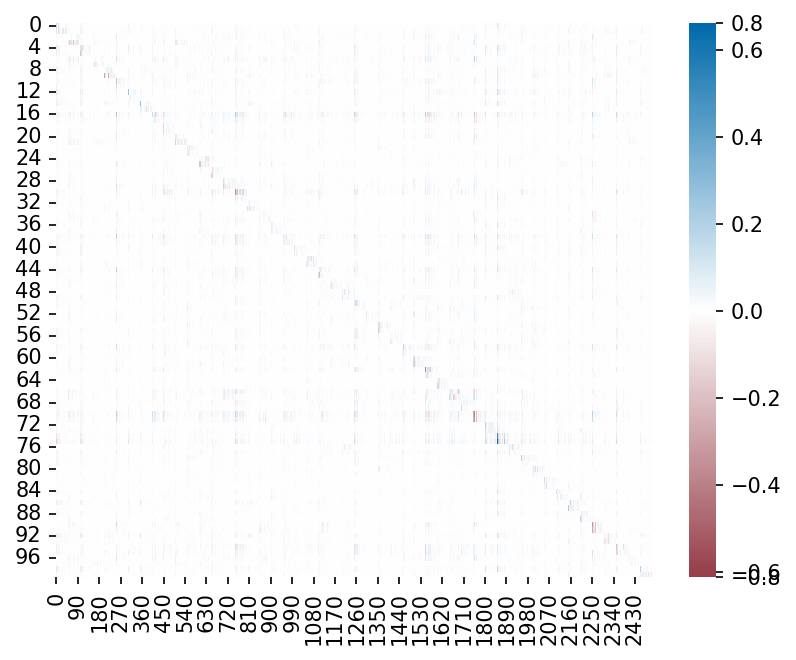

In [6]:
f = plt.figure()
sns.heatmap(dy, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(dy), vmax=np.max(dy))))

In [6]:
np.linalg.matrix_rank(H)

Array(100, dtype=int32)

<AxesSubplot: >

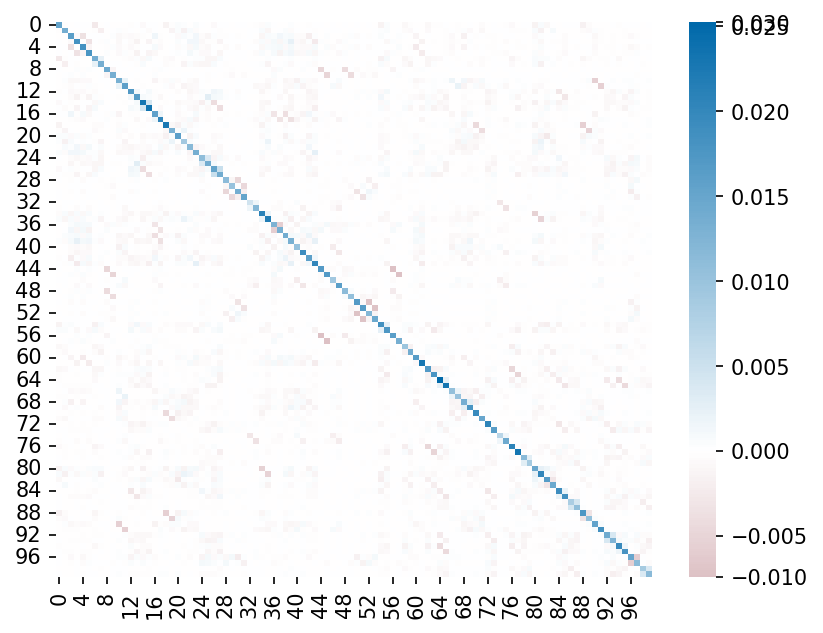

In [33]:
f = plt.figure()
sns.heatmap(H, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(H), vmax=np.max(H))))
#sns.heatmap(H-np.diag(np.diag(H)), cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(H-np.diag(np.diag(H))), vmax=np.max(H-np.diag(np.diag(H))))))

In [34]:
v, w = np.linalg.eigh(H)
w_sorted = np.transpose(np.transpose(w)[np.flip(np.argsort(v))])

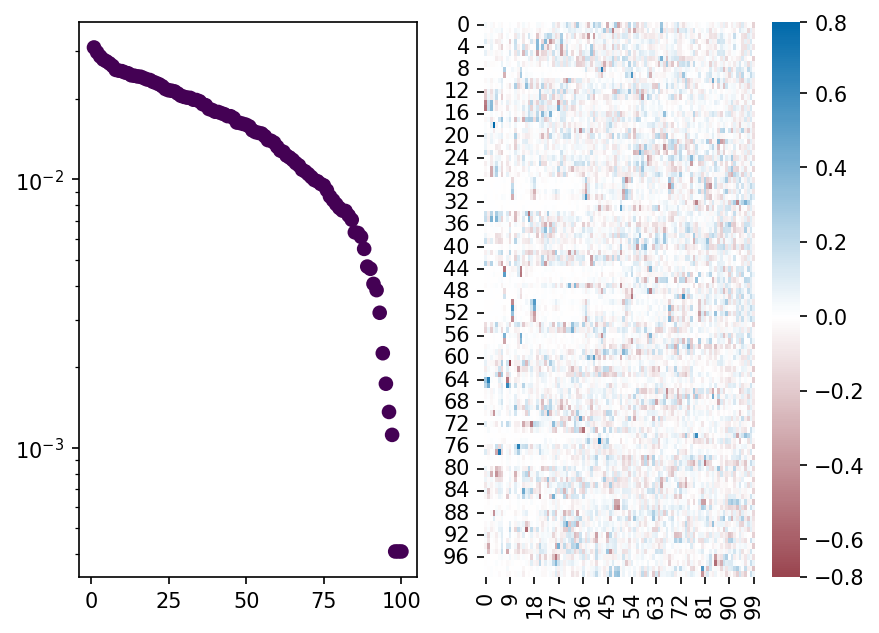

In [35]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter([i for i in range(1, len(v)+1)], np.flip(np.sort(np.abs(v))), c=[1 if i>0 else 0 for i in np.flip(np.sort(v))])
sns.heatmap(w_sorted, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(w_sorted), vmax=np.max(w_sorted))), ax=ax2)
ax1.set_yscale('log')

# not regularized

In [7]:
dy2, H2, J2 = d_y_star_d_x_outer(KL_divergence, X, Y_star)

Computing pairwise distances...
Starting binary search
Entered binary search function
Computing pairwise distances...
Starting binary search
Entered binary search function


In [10]:
u, s, v = np.linalg.svd(H2)
print(s)

[3.0680157e-02 2.9713739e-02 2.9054785e-02 2.8520126e-02 2.7667234e-02
 2.7429340e-02 2.7329864e-02 2.7009424e-02 2.6049443e-02 2.5951920e-02
 2.5765650e-02 2.4777707e-02 2.4625557e-02 2.3923425e-02 2.3715694e-02
 2.3152856e-02 2.3060579e-02 2.2834498e-02 2.2444539e-02 2.1977900e-02
 2.1540601e-02 2.1317633e-02 2.1226956e-02 2.1186503e-02 2.1055209e-02
 2.0968664e-02 2.0800320e-02 2.0613970e-02 2.0356262e-02 2.0272667e-02
 1.9802824e-02 1.9427793e-02 1.9222915e-02 1.8965621e-02 1.8919002e-02
 1.8670121e-02 1.8605791e-02 1.8090792e-02 1.7895600e-02 1.7700236e-02
 1.7479308e-02 1.7330566e-02 1.6937695e-02 1.6496938e-02 1.6352905e-02
 1.6132100e-02 1.5793962e-02 1.5509076e-02 1.5206266e-02 1.5127735e-02
 1.5031052e-02 1.4775842e-02 1.4178608e-02 1.3792941e-02 1.3437424e-02
 1.3323228e-02 1.3164983e-02 1.3118097e-02 1.2778703e-02 1.2300767e-02
 1.1910036e-02 1.1460282e-02 1.1363927e-02 1.0946467e-02 1.0686166e-02
 1.0626722e-02 1.0410825e-02 1.0219765e-02 9.8560760e-03 9.6238749e-03
 9.475

In [ ]:
f = plt.figure()
#sns.heatmap(H2, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(H2), vmax=np.max(H2))))
sns.heatmap(H2-np.diag(np.diag(H2)), cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(H2-np.diag(np.diag(H2))), vmax=np.max(H2-np.diag(np.diag(H2))))))

In [14]:
v, w = np.linalg.eigh(H2)
w_sorted = np.transpose(np.transpose(w)[np.flip(np.argsort(v))])

[9.9979852e-06 1.0002946e-05 1.0007382e-05 9.9702552e-04 1.2917105e-03
 1.4417573e-03 1.6422688e-03 2.2626487e-03 2.4822548e-03 2.6630946e-03
 3.2422272e-03 3.8212405e-03 4.1927244e-03 4.4568917e-03 4.6822149e-03
 4.9905577e-03 5.2630701e-03 5.6054052e-03 6.3834814e-03 6.5430650e-03
 7.0721330e-03 7.3549612e-03 7.4806660e-03 7.6945415e-03 7.7776308e-03
 7.9510501e-03 8.1370911e-03 8.3735492e-03 8.7800371e-03 8.9898119e-03
 9.4804512e-03 9.6103465e-03 9.8432135e-03 1.0065622e-02 1.0404347e-02
 1.0667502e-02 1.0774947e-02 1.1477718e-02 1.1648749e-02 1.1863815e-02
 1.2300966e-02 1.2799980e-02 1.2943881e-02 1.3017749e-02 1.3495244e-02
 1.3723577e-02 1.4188537e-02 1.4645782e-02 1.5136794e-02 1.5331546e-02
 1.5780101e-02 1.6160410e-02 1.6547581e-02 1.6801421e-02 1.7038640e-02
 1.7096948e-02 1.7181832e-02 1.7476210e-02 1.7929973e-02 1.8033089e-02
 1.8739520e-02 1.9190259e-02 1.9322820e-02 1.9439030e-02 1.9636011e-02
 2.0211479e-02 2.0268524e-02 2.0515716e-02 2.0590784e-02 2.0692719e-02
 2.120

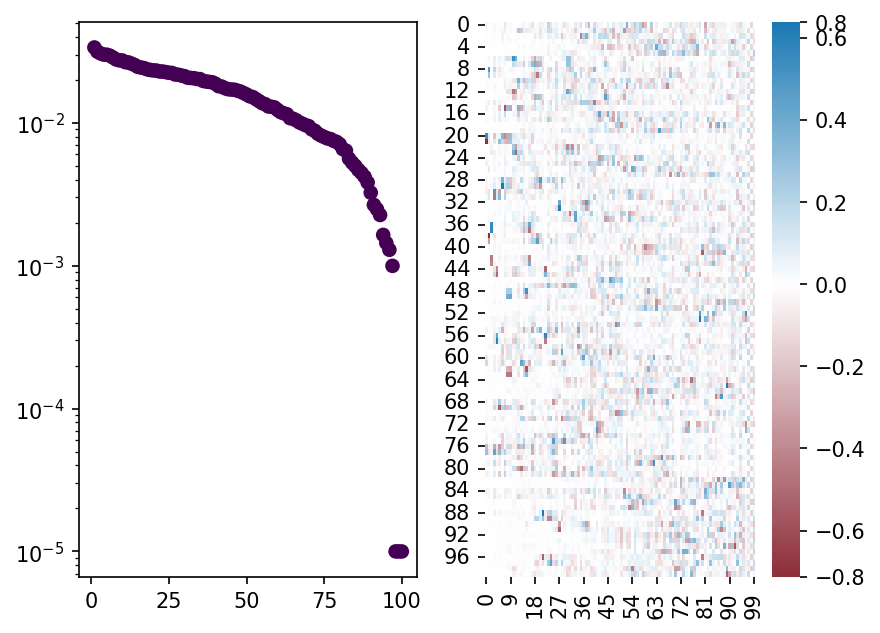

In [15]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter([i for i in range(1, len(v)+1)], np.flip(np.sort(np.abs(v))), c=[1 if i>0 else 0 for i in np.flip(np.sort(v))])
sns.heatmap(w_sorted, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(w_sorted), vmax=np.max(w_sorted))), ax=ax2)
ax1.set_yscale('log')